# MFN: Compare Different Voltages (SR830 vs. SR785)

In [1]:
%run test/basics.py

%matplotlib inline
import os
os.chdir('../../ana')

# IPython Interactions
import ipywidgets as wg
from IPython.display import display

## Define functions

In [9]:
def load_data(datapath):
    meas_data = {}
    meas_info = {}
    all_data = {}
    meas = ana.measurement.MeasurementClass()
    for f in datapath:
        f_info = meas.get_info_from_name(f)
        sr = f_info['Vin']
        nr = f_info['nr']
        meas_info[sr] = f_info
        meas_data[sr] = pd.read_csv(f, sep='\t')
        new_df = meas_data[sr]
        new_df['Vin'] = float(sr[:-2])
        if nr in all_data.keys():
            all_data[nr] = pd.concat([all_data[nr], new_df])
        else:
            all_data[nr] = new_df
    return meas_data, meas_info, all_data


### Calc PSD

In [11]:
def calc_PSD(meas_data):
    meas_obj = {}
    for sr, data_df in meas_data.items():
        if len(data_df['Vx']) % 1024:
            avg = len(data_df['Vx']) // 1024
            d = data_df['Vx'].iloc[:-(len(data_df['Vx']) % 1024)]
        else:
            d = data_df.Vx

        max_len = len(d)

        data = {
                    'data': d,
                    'info': {
                        'Nr': meas_info[sr]['nr'],
                        'rate': 1 / data_df.time.diff().mean(),
                        'length': max_len * data_df.time.diff().mean(),
                    }
                }

        meas_obj[sr] = ana.RAW(data,
                             rate=data['info']['rate'],
                             nof_first_spectra=32,
                             calc_first = True,
                             downsample=False,
                             )
    return meas_obj

In [12]:
#%matplotlib inline
import scipy.stats

def merge_data(meas_obj, cutoff_frequency=.9):
    diff_voltages = pd.DataFrame()
    for sr, m in meas_obj.items():
        s = m.avg_spec
        s = s[s.freq < cutoff_frequency]
        if len(s) < 2:
            continue
        newdf = pd.DataFrame()
        newdf['freq'] = s.freq
        newdf['S'] = s.S
        newdf['Vin'] = float(sr[:-2])
        diff_voltages = pd.concat([diff_voltages, newdf])
    return diff_voltages


def plot_PSD_classic(diff_voltages, title, groupby_category='Vin',
                     num=10, style=[['science'], {'context': 'talk', 'style': 'white', 'palette': 'bright',}]):
    set_style(style)
    c1 = sns.color_palette("hls", num)
    sns.set_palette(c1)
    fig, ax = plt.subplots(figsize=(12,8))
    #g = sns.relplot(x='freq', y='S', hue='Vin', data=diff_voltages, height=5, kind='line')
    grouped  = diff_voltages.groupby(groupby_category)
    for group in grouped.groups.keys():
        grouped.get_group(group).plot(x='freq', y='S', kind='line', 
                                      loglog=True, ax=ax, 
                                      label=group,
                                      xlabel='Frequency [Hz]',
                                      ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]',
                                     )
    ax.set_title(title)
    #save_plot('m506', 'png')

def show_PSD_classic(diff_voltages, title, ax=None, groupby_category='Vin',
                     num=10, style=[['science'], {'context': 'talk', 'style': 'white', 'palette': 'bright',}]):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,8))
    set_style(style)
    c1 = sns.color_palette("hls", num)
    sns.set_palette(c1)
    #g = sns.relplot(x='freq', y='S', hue='Vin', data=diff_voltages, height=5, kind='line')
    grouped  = diff_voltages.groupby(groupby_category)
    for group in grouped.groups.keys():
        grouped.get_group(group).plot(x='freq', y='S', kind='line', 
                                      loglog=True, ax=ax, 
                                      label=group,
                                      xlabel='Frequency [Hz]',
                                      ylabel='$S_{V_H}$ [$\\mathrm{V}^2/\\mathrm{Hz}$]',
                                     )
    ax.set_title(title)
    return ax


In [13]:
from matplotlib import cm
from matplotlib.colors import LogNorm

def plot_PSD_contour(meas_obj, diff_voltages, title,
                     cutoff_frequency=.9,
                     groupby_category='Vin'):
    diff_voltages_contour = pd.DataFrame()
    for sr, m in meas_obj.items():
        s = m.avg_spec
        s = s[s.freq < cutoff_frequency]
        if len(s) < 2:
            continue
        diff_voltages_contour[float(sr[:-2])] = s.S

    v = diff_voltages[groupby_category].unique()
    v.sort()
    frequencies = diff_voltages.freq.unique()
    smin, smax = diff_voltages.S.min(), diff_voltages.S.max()
    levels = np.logspace(np.log10(smin),
                         np.log10(smax), 10)

    fig, ax = plt.subplots(figsize=(12,8))
    cs = ax.contourf(v, frequencies, diff_voltages_contour,
                     norm=LogNorm(vmin=smin, vmax=smax),
                     levels=levels,
                     cmap=plt.cm.Blues,
                     )
    cbar = plt.gcf().colorbar(cs, ax=ax)
    cbar.set_label('$S_V^{V_{in}} (f)$')
    cbar.set_ticklabels(['%.1e' % _ for _ in levels])
    ax.set_yscale('log')
    ax.set_ylabel('$f$ [Hz]')
    ax.set_xlabel('$V_{in}$ [$m$V]')
    ax.set_title(title)


## Load Data

In [14]:
datapath = glob('./data/MFN/m506/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
meas_obj.items()

dict_items([('3000.0mV', RAW (Nr. 506)
), ('3500.0mV', RAW (Nr. 506)
), ('5000.0mV', RAW (Nr. 506)
), ('4000.0mV', RAW (Nr. 506)
), ('4500.0mV', RAW (Nr. 506)
), ('1000.0mV', RAW (Nr. 506)
), ('2500.0mV', RAW (Nr. 506)
), ('1500.0mV', RAW (Nr. 506)
), ('2000.0mV', RAW (Nr. 506)
), ('500.0mV', RAW (Nr. 506)
)])

## Plot PSD

### Classic

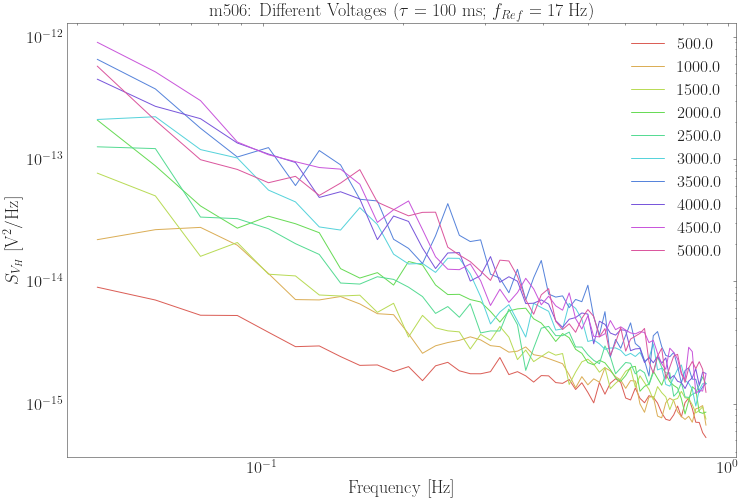

In [15]:
diff_voltages = merge_data(meas_obj)
plot_PSD_classic(diff_voltages, 'm506: Different Voltages ($\\tau = 100~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)')

### Contour

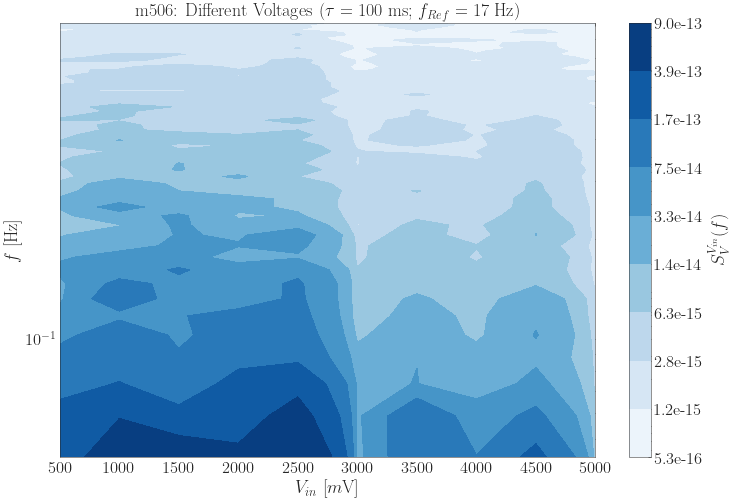

In [16]:
plot_PSD_contour(meas_obj, diff_voltages, 'm506: Different Voltages ($\\tau = 100~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)')

## Load m499

In [17]:
datapath = glob('./data/MFN/m499/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
meas_obj.items()

dict_items([('2000.0mV', RAW (Nr. 499)
), ('1500.0mV', RAW (Nr. 499)
), ('500.0mV', RAW (Nr. 499)
), ('2500.0mV', RAW (Nr. 499)
), ('1000.0mV', RAW (Nr. 499)
), ('4500.0mV', RAW (Nr. 499)
), ('4000.0mV', RAW (Nr. 499)
), ('5000.0mV', RAW (Nr. 499)
), ('3500.0mV', RAW (Nr. 499)
), ('3000.0mV', RAW (Nr. 499)
)])

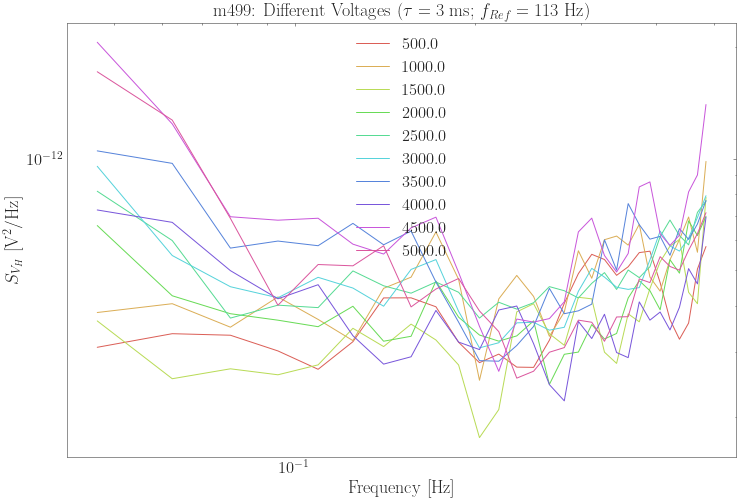

In [18]:
diff_voltages = merge_data(meas_obj, cutoff_frequency=.5)
plot_PSD_classic(diff_voltages, 'm499: Different Voltages ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)')

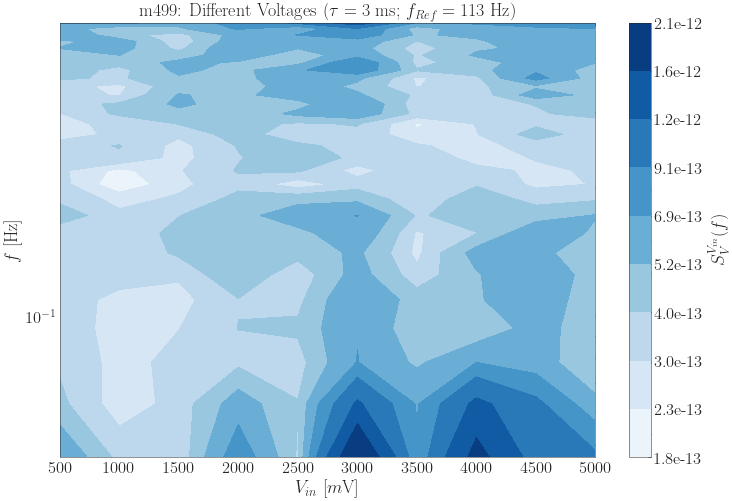

In [19]:
plot_PSD_contour(meas_obj, diff_voltages, 'm499: Different Voltages ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 113~\\mathrm{Hz}$)',
                cutoff_frequency=.5)

## m498

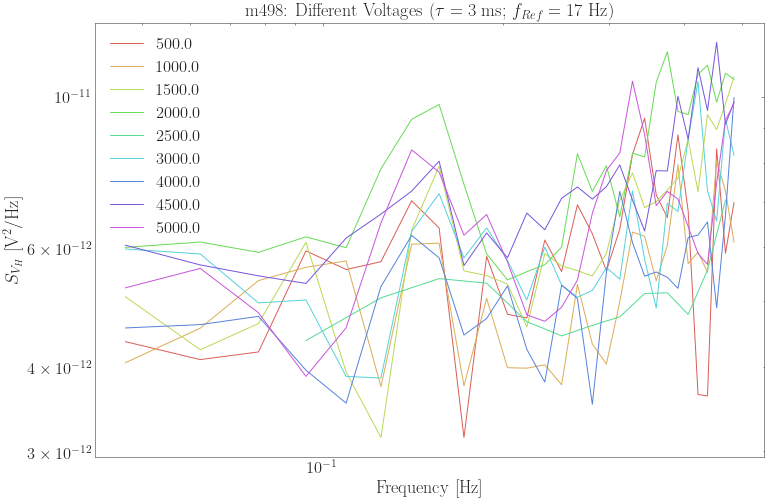

In [20]:
datapath = glob('./data/MFN/m498/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj, cutoff_frequency=.5)
title = 'm498: Different Voltages ($\\tau = 3~\\mathrm{ms}$; $f_{Ref} = 17~\\mathrm{Hz}$)'
plot_PSD_classic(diff_voltages, title)

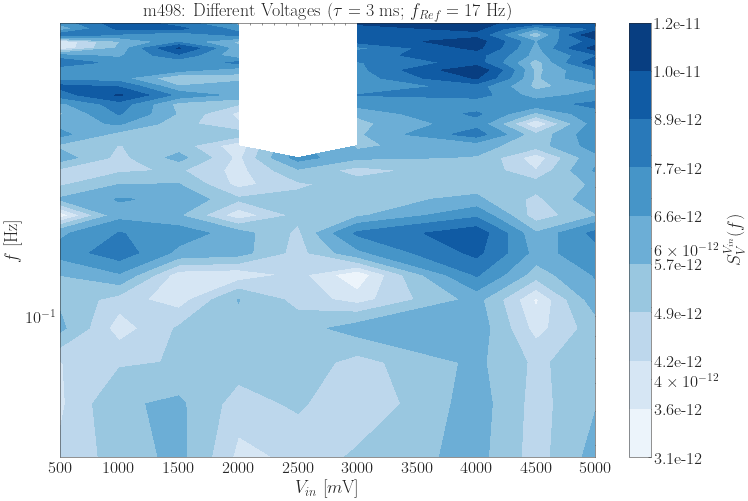

In [21]:
plot_PSD_contour(meas_obj, diff_voltages, title, cutoff_frequency=.5)

In [23]:
eva = ana.HandleM(directory='data/SR785')


/Users/jp/Projects/Code/method-paper/ana/ana/handle.py:103: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_folder(file_list, **kwargs)


In [25]:
m = ana.Hloop(57)

## Compare with SR785

### SR785

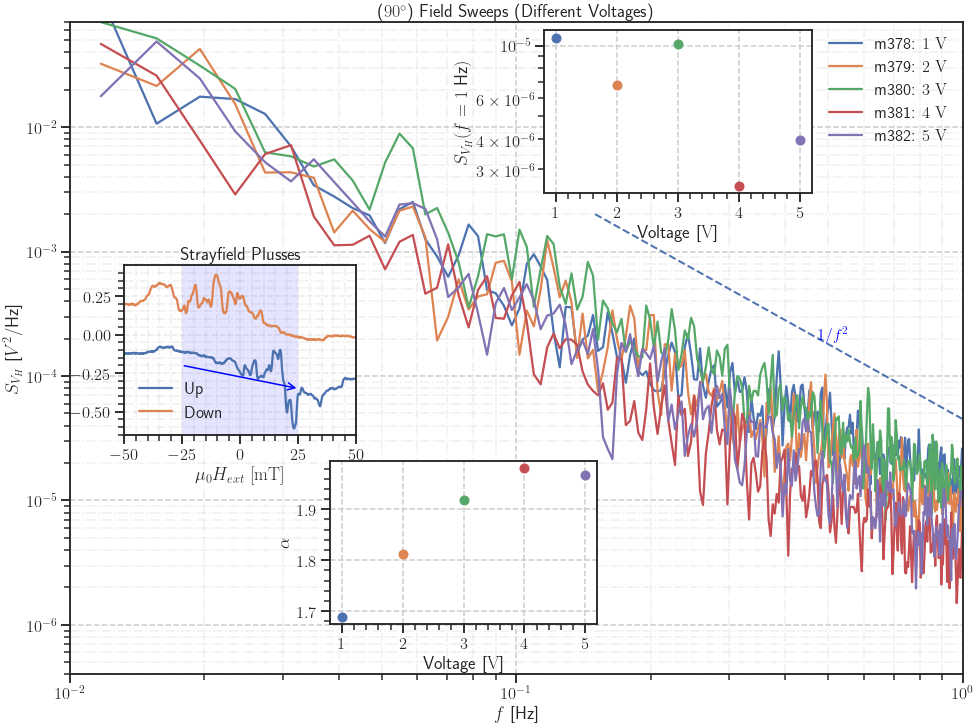

In [27]:
eva.style.set_style(default=True, grid=True, 
                 size='talk', style='ticks', latex=True,
                 palette='deep')

lofm = {}
to_show = {}
for i in range(1,6):
    to_show[i+377] = i

for nr, content in to_show.items():
    lofm[nr] = ["$%s\\;\\mathrm{V}$" % (
                content
                ),{}]

fig, ax = eva.plot(lofm,
         #fit_range=(2e-2, 7e-1),
         #show_fit=True,
         plot_settings=dict(
             title='($90^\\circ$) Field Sweeps (Different Voltages)',
             xlim=(1e-2, 1e0),
             ylim=(4e-7, 7e-2)),
         f_settings=dict(disable=True,
             xmin=5e-2,
             ymin=1e-5),
         f2_settings=dict(
             xmin=1.5e-1,
             ymin=2e-3,
             ),
         )

# Inset with Strayfield
with sns.color_palette('deep'):
    inset = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(.07, .38, .26, .26),
                       bbox_transform=ax.transAxes)
    m.plot_strayfield(inset, 'Strayfield Plusses', 
                      nolegend=True,)
    inset.legend(['Up',# ($-M_S \\rightarrow +M_S$)', 
                  'Down'])# ($+M_S \\rightarrow -M_S$)'])
    inset.grid(b=True, alpha=.4)
    inset.set_xlim(-50, 50)
    inset.set_ylim(-.65, .45)
    inset.set_xticks([-50+25*_ for _ in range(5)])
    #inset.set_xticks([-45+10*_ for _ in range(10)], minor=True)
    inset.grid(b=True, which='minor', color='#cccccc', 
               linestyle='-.', alpha=.3)
    #inset.set_xlabel('')
    inset.set_ylabel('')

    y1, y2 = -1, 2
    inset.fill([-25, -25, 25, 25], [y1, y2, y2, y1], 'blue', alpha=.1)
    inset.annotate("", xy=(25, -.35), xytext=(-25, -.2),
                 arrowprops=dict(arrowstyle="->", color='blue'))

# Inset showing fitted data
with sns.color_palette("deep"):
    inset2 = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(.54, .75, .3, .25),
                       bbox_transform=ax.transAxes)
    inset3 = inset_axes(ax, width='100%', height='100%', 
                       bbox_to_anchor=(.3, .09, .3, .25),
                       bbox_transform=ax.transAxes)

    for nr, content in to_show.items():
        intercept, slope = eva[nr].fit(fit_range=(2e-2, 7e-1))
        voltage = content

        inset2.plot(voltage, 10**intercept, 'o')
        inset3.plot(voltage, -slope, 'o')

    inset2.set_xlabel('Voltage [$\mathrm{V}$]')
    inset2.set_ylabel('$S_{V_H} (f=1\\;$Hz$)$')
    inset2.set_yscale('log')

    inset3.set_xlabel('Voltage [$\mathrm{V}$]')
    inset3.set_ylabel('$\\alpha$')


### SR830DAQ

#### m506

/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34078/1220830970.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnf'] = np.log10(fit_area.freq)
/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34078/1220830970.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnS'] = np.log10(fit_area.S)


Text(0, 0.5, '$\\alpha$')

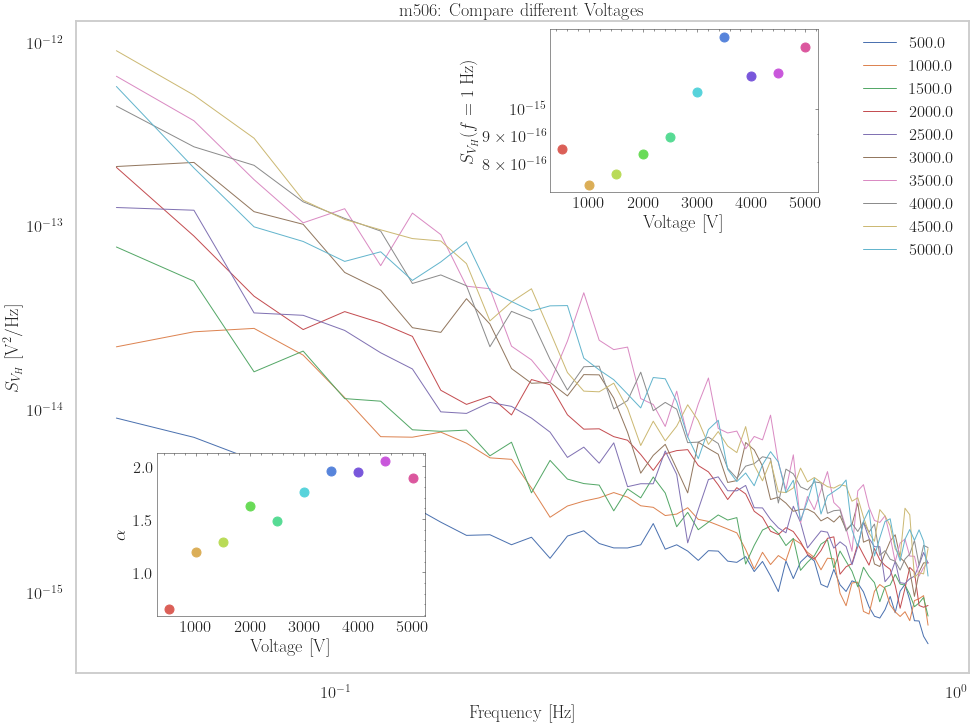

In [28]:
datapath = glob('./data/MFN/m506/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj)
fig, ax = plt.subplots(figsize=(16,12))
show_PSD_classic(diff_voltages, 'm506: Compare different Voltages', ax=ax)

inset2 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.54, .75, .3, .25),
                   bbox_transform=ax.transAxes)
inset3 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.1, .1, .3, .25),
                   bbox_transform=ax.transAxes)

grouped = diff_voltages.groupby('Vin')
for group in grouped.groups.keys():
    g = grouped.get_group(group)
    fit_area = g.query('freq > %f and freq < %f' % (2e-2, 7e-1))
    fit_area['lnf'] = np.log10(fit_area.freq)
    fit_area['lnS'] = np.log10(fit_area.S)
    fit = scipy.stats.linregress(fit_area.lnf, fit_area.lnS)
    intercept, slope = fit.intercept, -fit.slope
    voltage = group

    inset2.plot(voltage, 10**intercept, 'o')
    inset3.plot(voltage, slope, 'o')

inset2.set_xlabel('Voltage [$\mathrm{V}$]')
inset2.set_ylabel('$S_{V_H} (f=1\\;$Hz$)$')
inset2.set_yscale('log')

inset3.set_xlabel('Voltage [$\mathrm{V}$]')
inset3.set_ylabel('$\\alpha$')


#### m508

/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34078/2035017012.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnf'] = np.log10(fit_area.freq)
/var/folders/nm/0s3x_nnn1ss1n7rd1px5gqsr0000gn/T/ipykernel_34078/2035017012.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fit_area['lnS'] = np.log10(fit_area.S)


Text(0, 0.5, '$\\alpha$')

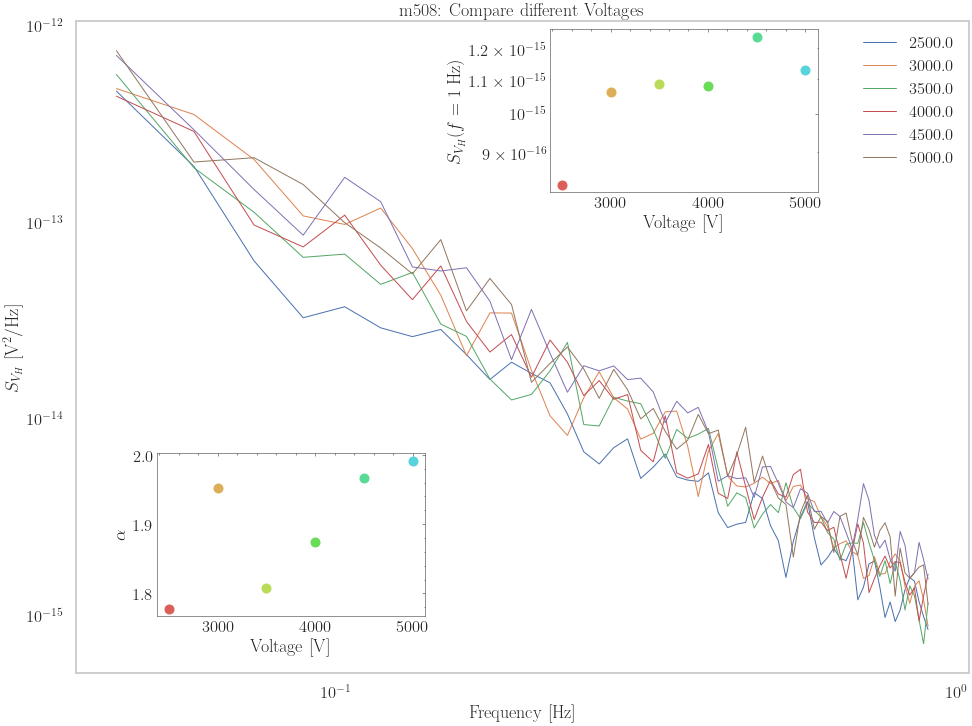

In [29]:
datapath = glob('./data/MFN/m508/*')
meas_data, meas_info, all_data = load_data(datapath)
meas_obj = calc_PSD(meas_data)
diff_voltages = merge_data(meas_obj)
fig, ax = plt.subplots(figsize=(16,12))
show_PSD_classic(diff_voltages, 'm508: Compare different Voltages', ax=ax)

inset2 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.54, .75, .3, .25),
                   bbox_transform=ax.transAxes)
inset3 = inset_axes(ax, width='100%', height='100%', 
                   bbox_to_anchor=(.1, .1, .3, .25),
                   bbox_transform=ax.transAxes)

grouped = diff_voltages.groupby('Vin')
for group in grouped.groups.keys():
    g = grouped.get_group(group)
    fit_area = g.query('freq > %f and freq < %f' % (2e-2, 7e-1))
    fit_area['lnf'] = np.log10(fit_area.freq)
    fit_area['lnS'] = np.log10(fit_area.S)
    fit = scipy.stats.linregress(fit_area.lnf, fit_area.lnS)
    intercept, slope = fit.intercept, -fit.slope
    voltage = group

    inset2.plot(voltage, 10**intercept, 'o')
    inset3.plot(voltage, slope, 'o')

inset2.set_xlabel('Voltage [$\mathrm{V}$]')
inset2.set_ylabel('$S_{V_H} (f=1\\;$Hz$)$')
inset2.set_yscale('log')

inset3.set_xlabel('Voltage [$\mathrm{V}$]')
inset3.set_ylabel('$\\alpha$')
